In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [80]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

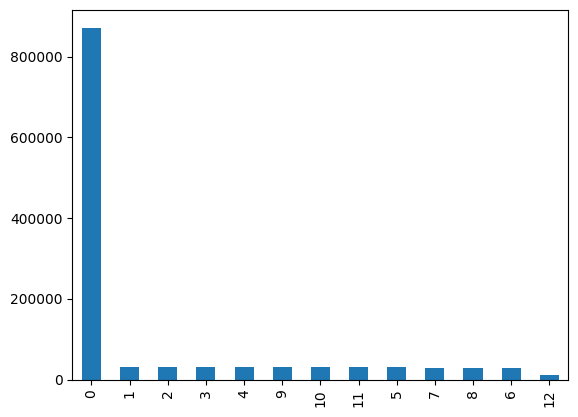

In [81]:
pd.value_counts(df['Activity']).plot.bar()

In [82]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [83]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [84]:
workers_info = []
energy_for_edge_at_start = 100000

# data, cluster no, edge score, model - coeff, model - intercept, energy consumed, acc
for i in range(5):
    for j in range(5):
        worker_data = pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id = i
        worker_score = 0
        worker_coef = 0
        worker_intercept = 0
        worker_energy = []
        energy_acc = []
        energy = energy_for_edge_at_start
        workers_info.append([worker_data, worker_id, worker_coef, worker_score,
                             worker_intercept, worker_energy, energy_acc, energy])

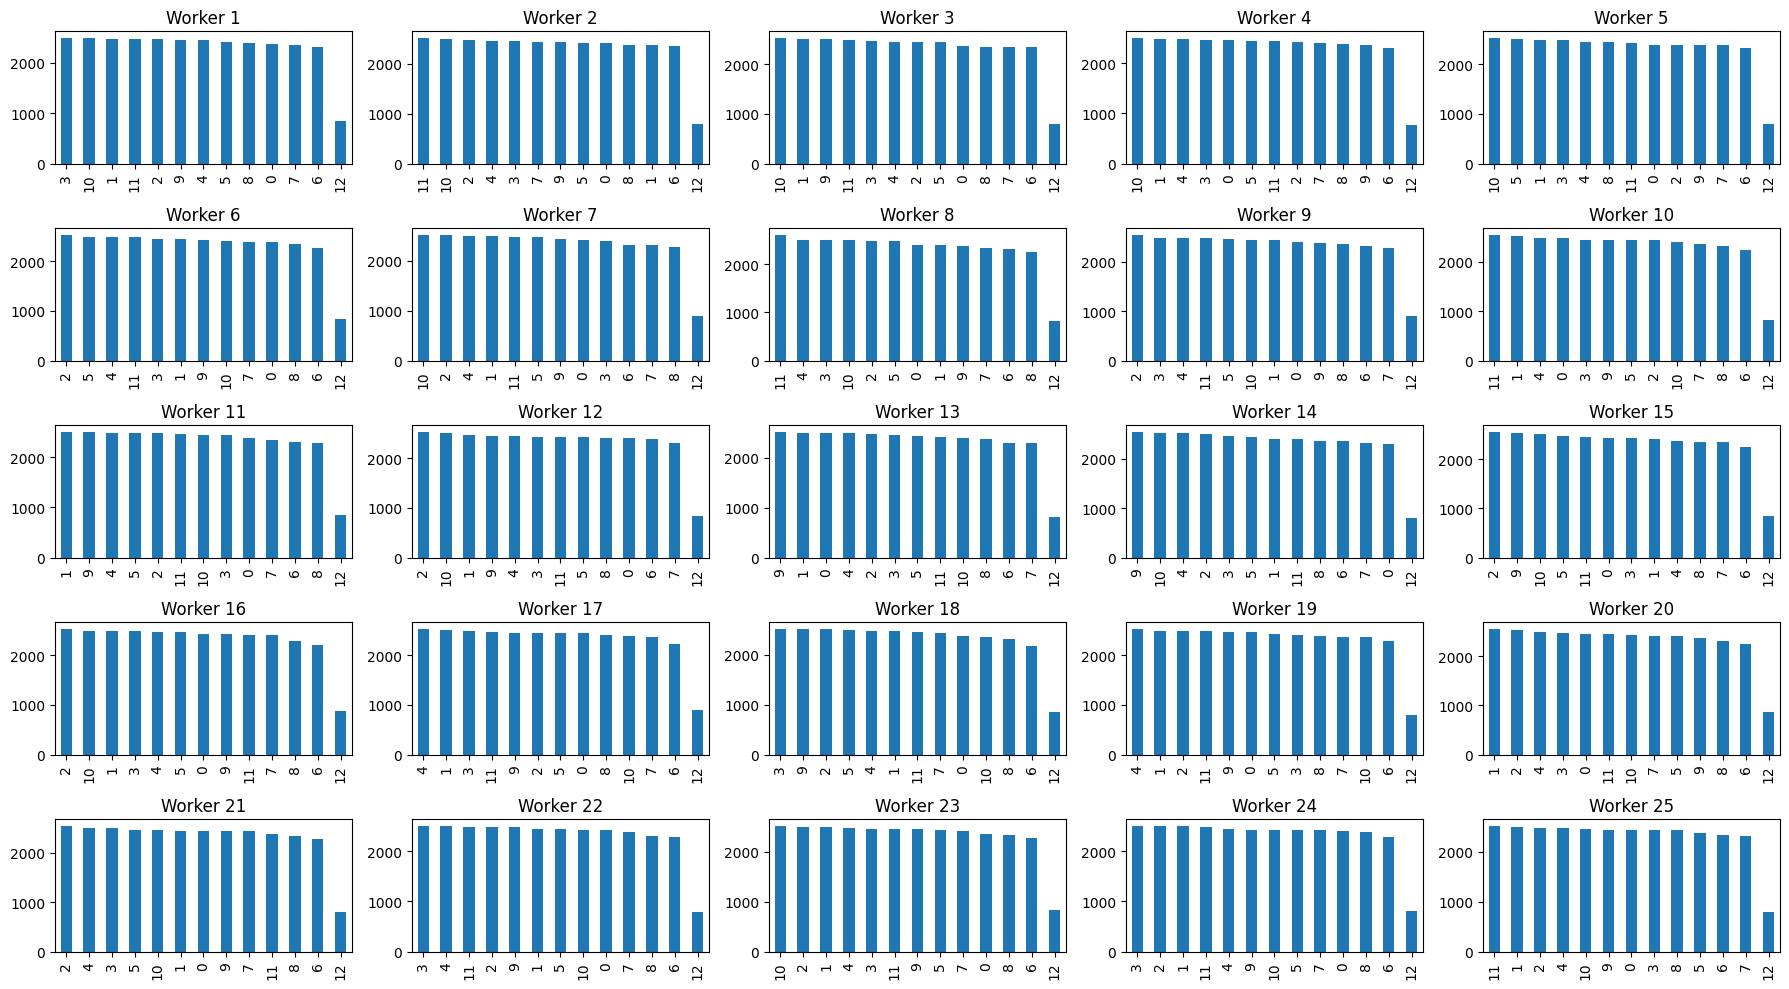

In [85]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()

In [105]:
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        # Use joblib.load to handle non-compressed models
        model = joblib.load(io.BytesIO(message))
        return model, None
    except Exception:
        pass

    try:
        # Handle gzipped models
        decompressed_byte_array = zlib.decompress(message)
        model = joblib.load(io.BytesIO(decompressed_byte_array))
        return model, None
    except Exception:
        pass

    # Return default values if extraction fails
    return None, None


def compress(model):
    try:
        # Save the model to a BytesIO object using joblib.dump
        model_bytesio = io.BytesIO()
        joblib.dump(model, model_bytesio)

        # Get the serialized model bytes
        model_bytes = model_bytesio.getvalue()

        # Compress the serialized model using gzip
        compressed_model = gzip.compress(model_bytes)

        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception:
        return None


In [87]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power = 1
    # energy = power * time = time = data / power = data
    return data

def terminate(accuracy, best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

def local_worker_training(worker_num, global_model):
    # Shuffle the data before splitting
    workers_info[worker_num][0] = workers_info[worker_num][0].sample(frac=1, random_state=42)

    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize variables before the if-else block
    energy_consumption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_consumption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) +
                                                          sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train):
            sample_weights = np.repeat(sample_weights, len(lX_train) // len(sample_weights) + 1)[:len(lX_train)]

    else:
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_consumption_in_local += max_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_consumption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_consumption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_rounds,
          "energy remaining:", workers_info[worker_num][7])

In [88]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [89]:
def cal_batter_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100


In [90]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [107]:
from sklearn.ensemble import RandomForestClassifier
import copy

def global_aggregation(global_model):
    training_workers(global_model)  # Pass the global_model to training_workers
    cal_edge_score()
    cal_clusters_head()

    # Use RandomForestClassifier instead of SGDClassifier
    new_global_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a list to store aggregated trees
    aggregated_trees = []

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model, _ = extract(workers_info[i][2])  # extract returns a tuple

        if worker_model:
            # Extract the trees from the worker's RandomForestClassifier
            trees = worker_model.estimators_

            # Aggregate the trees
            if num_contributing_workers == 0:
                # If it's the first worker, simply copy the trees
                aggregated_trees = copy.deepcopy(trees)
            else:
                # Aggregate subsequent trees
                for j in range(len(aggregated_trees)):
                    aggregated_trees[j].tree_ += trees[j].tree_

            num_contributing_workers += 1

    # Normalize the aggregated trees by dividing the tree values by the number of contributing workers
    if num_contributing_workers > 0:
        for tree in aggregated_trees:
            tree.tree_ = tree.tree_ / num_contributing_workers

    # Set the aggregated trees to the new_global_model
    new_global_model.estimators_ = aggregated_trees

    return new_global_model


In [108]:
max_global_rounds = 15
acc = []
global_model = None  # Initialize global_model outside the loop

for i in range(max_global_rounds):
    global_model = global_aggregation(global_model)  # Pass the current global_model
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

            # Additional debugging information
            # print(f"local worker: {j} acc: {workers_info[j][6][i]} round no: {i} energy remaining: {workers_info[j][5]}")

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)


local worker: 0 acc: 0.9496666666666667 round no: 100 energy remaining: 99990.0
local worker: 1 acc: 0.9496666666666667 round no: 100 energy remaining: 99752.0
local worker: 2 acc: 0.9453333333333334 round no: 100 energy remaining: 99993.0
local worker: 3 acc: 0.952 round no: 100 energy remaining: 99819.0
local worker: 4 acc: 0.9503333333333334 round no: 100 energy remaining: 99820.0
local worker: 5 acc: 0.9516666666666667 round no: 100 energy remaining: 99996.0
local worker: 6 acc: 0.9505 round no: 100 energy remaining: 99820.0
local worker: 7 acc: 0.9523333333333334 round no: 100 energy remaining: 99996.0
local worker: 8 acc: 0.952 round no: 100 energy remaining: 99820.0
local worker: 9 acc: 0.9461666666666667 round no: 100 energy remaining: 99820.0
local worker: 10 acc: 0.9501666666666667 round no: 100 energy remaining: 99996.0
local worker: 11 acc: 0.9441666666666667 round no: 100 energy remaining: 99820.0
local worker: 12 acc: 0.9493333333333334 round no: 100 energy remaining: 999

In [119]:
total_energy_per_round=[]
energy_per_round=[]
total_energy=0
for i in range(15):
    energy=0
    for j in range(num_of_workers):
        total_energy+=workers_info[j][5][i]
        energy+=workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
energy_per_round

[25.0,
 905.0,
 729.0,
 905.0,
 729.0,
 985.0,
 1225.0,
 1465.0,
 1225.0,
 1497.0,
 1497.0,
 2233.0,
 2233.0,
 1865.0,
 1497.0]

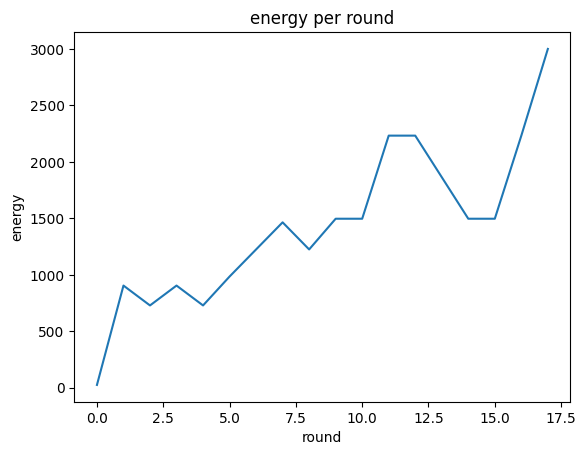

In [111]:
# @title graph
plt.plot(energy_per_round)
plt.xlabel("round")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()

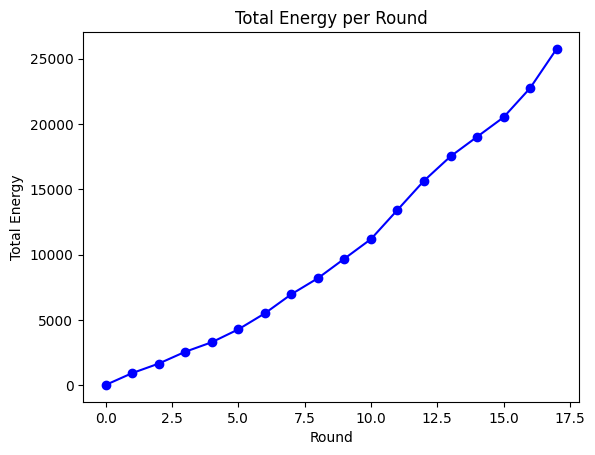

In [114]:
import matplotlib.pyplot as plt

# Assuming total_energy_per_round is already defined
plt.plot(total_energy_per_round, marker='o', linestyle='-', color='b')  # Customize markers, linestyle, and color
plt.xlabel("Round")
plt.ylabel("Total Energy")
plt.title("Total Energy per Round")
plt.show()


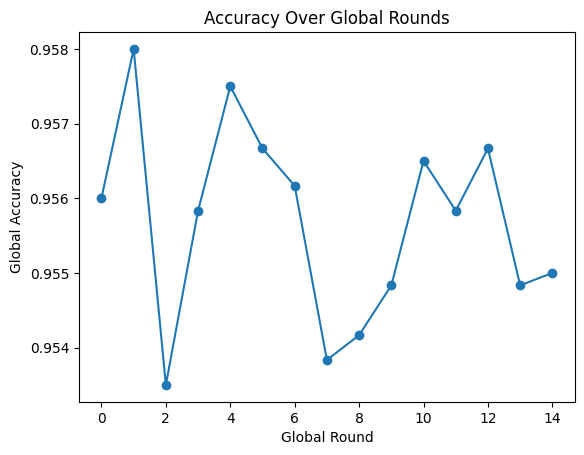

In [121]:
plt.plot(range(max_global_rounds), acc, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Accuracy Over Global Rounds")
plt.show()


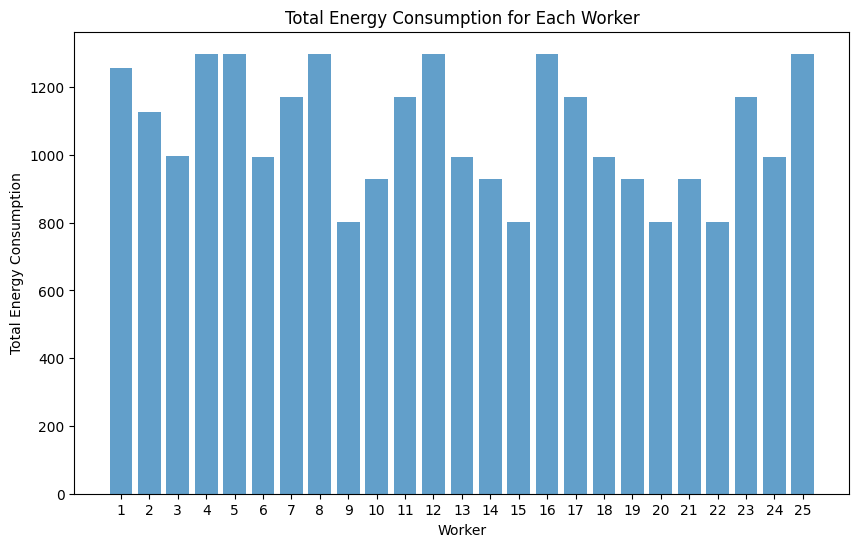

In [127]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the total energy consumption for each worker over local rounds
total_energy_per_worker = [sum(workers_info[i][5]) for i in range(num_of_workers)]

# Plotting a bar graph
ax.bar(range(1, num_of_workers + 1), total_energy_per_worker, align='center', alpha=0.7)
ax.set_xticks(range(1, num_of_workers + 1))
ax.set_xlabel('Worker')
ax.set_ylabel('Total Energy Consumption')
ax.set_title('Total Energy Consumption for Each Worker')

plt.show()


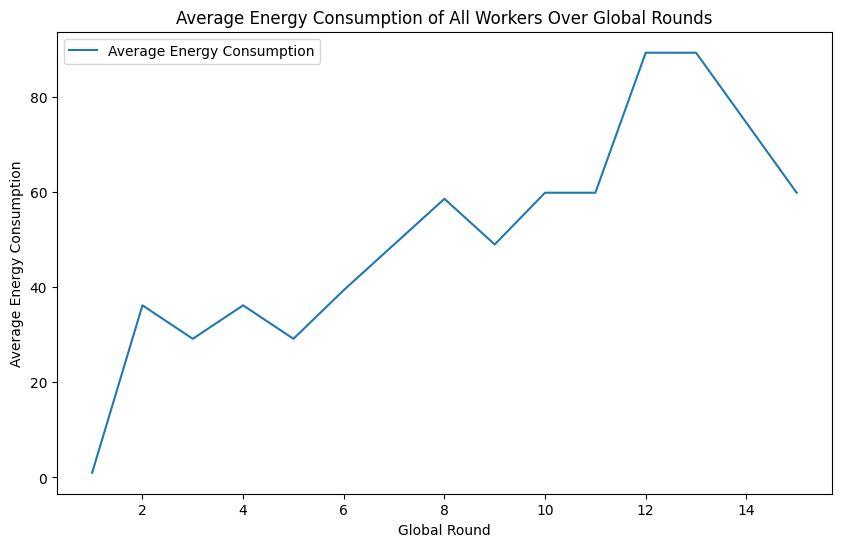

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list `workers_info` that contains information about each worker's energy consumption

# Calculate the average energy consumption for each global round
average_energy_consumption_per_round = np.mean([worker_info[5][:max_global_rounds] for worker_info in workers_info], axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, max_global_rounds + 1), average_energy_consumption_per_round, label='Average Energy Consumption')
ax.set_xlabel('Global Round')
ax.set_ylabel('Average Energy Consumption')
ax.legend()
plt.title('Average Energy Consumption of All Workers Over Global Rounds')
plt.show()
